In [2]:
# Implements a buffer for faster readout
import pyvisa
import datetime
import json
import time
import numpy as np
import matplotlib.pyplot as plt

In [120]:
# Connect to keithley
rm = pyvisa.ResourceManager()
print(rm.list_resources())
collector = rm.open_resource('GPIB1::09::INSTR')
mass_driver = rm.open_resource('GPIB1::11::INSTR')
readback = rm.open_resource('GPIB1::10::INSTR')

print("Using " + collector.query('*IDN?'))
print("Using " + mass_driver.query('*IDN?'))
print("Using " + readback.query('*IDN?'))

('ASRL1::INSTR', 'ASRL4::INSTR', 'GPIB1::9::INSTR', 'GPIB1::10::INSTR', 'GPIB1::11::INSTR')
Using Keithley Instruments Inc., Model 2657A, 1409200, 1.1.8

Using Keithley Instruments Inc., Model 2657A, 4033749, 1.1.8

Using Keithley Instruments Inc., Model 2657A, 1409197, 1.2.0



In [121]:
collector.write('smua.reset()')
mass_driver.write('smua.reset()')
readback.write('smua.reset()')

14

In [133]:
data_dir = 'C://Users//addiaz15//Desktop//keithleydataDec19//'
experiment_name = 'ms sweep testing'
current_limit = 1.0e-9      # changed the limit from nano amp
current_limit_ardara = 1.0e-6
voltage_limit = 100
measurement_interval = 1.0e-7
operating_voltage = 0 # used to be 0 volts
measurement_count = 10
iterates = 200
mass_driver_range = np.linspace(0,.9,iterates)

In [134]:
# Configure as voltage source
collector.write(' \
    smua.source.func = smua.OUTPUT_DCVOLTS \n\
    display.smua.measure.func = display.MEASURE_DCAMPS \n\
    smua.measure.autozero = smua.AUTOZERO_ONCE \n\
    smua.measure.autorangei = smua.AUTORANGE_OFF \n\
    smua.measure.rangei = {i_lim} \n\
    smua.measure.rangev = {v_lim} \n\
    smua.source.limiti = {i_lim} \n\
    smua.measure.adc = smua.ADC_INTEGRATE \n\
    smua.measure.interval = {m_int} \n\
    smua.measure.delay = smua.DELAY_OFF \n\
    smua.source.output = smua.OUTPUT_ON \n\
    smua.measure.count = {m_count} \
    '.format(i_lim = current_limit, v_lim = voltage_limit, m_count = measurement_count, m_int=measurement_interval))

489

In [135]:
# Configure as current source (0A) to measure the readback voltage
mass_driver.write(' \
    smua.source.func = smua.OUTPUT_DCVOLTS \n\
    display.smua.measure.func = display.MEASURE_DCVOLTS \n\
    smua.measure.autozero = smua.AUTOZERO_ONCE \n\
    smua.measure.autorangei = smua.AUTORANGE_OFF \n\
    smua.measure.rangei = {i_lim} \n\
    smua.measure.rangev = {v_lim} \n\
    smua.source.limitv = {v_lim} \n\
    smua.measure.adc = smua.ADC_INTEGRATE \n\
    smua.measure.interval = {m_int} \n\
    smua.measure.delay = smua.DELAY_OFF \n\
    smua.source.output = smua.OUTPUT_ON \n\
    smua.measure.count = {m_count} \
    '.format(i_lim = current_limit_ardara, v_lim = voltage_limit, m_count = measurement_count, m_int=measurement_interval))

488

In [136]:
# Configure as voltage source
readback.write(' \
    smua.source.func = smua.OUTPUT_DCAMPS \n\
    display.smua.measure.func = display.MEASURE_DCVOLTS \n\
    smua.measure.autozero = smua.AUTOZERO_ONCE \n\
    smua.measure.autorangei = smua.AUTORANGE_OFF \n\
    smua.measure.rangei = {i_lim} \n\
    smua.measure.rangev = {v_lim} \n\
    smua.source.limiti = {i_lim} \n\
    smua.measure.adc = smua.ADC_INTEGRATE \n\
    smua.measure.interval = {m_int} \n\
    smua.measure.delay = smua.DELAY_OFF \n\
    smua.source.output = smua.OUTPUT_ON \n\
    smua.measure.count = {m_count} \
    '.format(i_lim = current_limit_ardara, v_lim = voltage_limit, m_count = measurement_count, m_int=measurement_interval))

489

In [137]:
collector.write(' \
    smua.nvbuffer1.clear() \n\
    smua.nvbuffer2.clear() \n\
	smua.nvbuffer1.collecttimestamps	= 1 \n\
	smua.nvbuffer1.collectsourcevalues	= 1 \n\
')

mass_driver.write(' \
    smua.nvbuffer1.clear() \n\
    smua.nvbuffer2.clear() \n\
	smua.nvbuffer1.collecttimestamps	= 1 \n\
	smua.nvbuffer1.collectsourcevalues	= 1 \n\
')

readback.write(' \
    smua.nvbuffer1.clear() \n\
    smua.nvbuffer2.clear() \n\
	smua.nvbuffer1.collecttimestamps	= 1 \n\
	smua.nvbuffer1.collectsourcevalues	= 1 \n\
')

139

In [150]:
aggregate_collector_measurements = []
aggregate_mass_driver_measurements = []
aggregate_readback_measurements = []
aggregate_timestamps = []


print('Currently driving at 0v for 10 seconds')
# mass_driver.write('smua.source.output = smua.OUTPUT_OFF')
mass_driver.write('smua.source.levelv = 0')
#mass_driver.write('smua.source.output = smua.OUTPUT_ON')
mass_driver.write('smua.measure.v(smua.nvbuffer1)')
collector.write('smua.measure.iv(smua.nvbuffer1, smua.nvbuffer2)')

time.sleep(10)




for driving_voltage in mass_driver_range:
    print('Currently driving at %s'%driving_voltage)
   # mass_driver.write('smua.source.output = smua.OUTPUT_OFF')
    mass_driver.write('smua.source.levelv = %s'%driving_voltage)
    #mass_driver.write('smua.source.output = smua.OUTPUT_ON')
    mass_driver.write('smua.measure.v(smua.nvbuffer1)')

    collector.write('smua.source.levelv = %s'%operating_voltage)
    collector.write('smua.measure.iv(smua.nvbuffer1, smua.nvbuffer2)')

    readback.write('smua.source.leveli = 0')
    readback.write('smua.measure.iv(smua.nvbuffer1, smua.nvbuffer2)')

    collector_measurements = []
    mass_driver_measurements = []
    readback_measurements = []
    timestamps = []

    counter = 1
    for i in range(measurement_count):
        try:
            raw_collector_measurement = collector.query('print(smua.nvbuffer1[{iterate}])'.format(iterate=counter))
            raw_mass_driver_measurement = mass_driver.query('print(smua.nvbuffer1[{iterate}])'.format(iterate=counter))
            raw_readback_measurement = readback.query('print(smua.nvbuffer2[{iterate}])'.format(iterate=counter))
            raw_time = collector.query('print(smua.nvbuffer1.timestamps[{iterate}])'.format(iterate=counter))

            collector_measurements.append(float(raw_collector_measurement[:-1]))
            mass_driver_measurements.append(float(raw_mass_driver_measurement[:-1]))
            readback_measurements.append(float(raw_readback_measurement[:-1]))
            timestamps.append(float(raw_time[:-1]))

            counter += 1

        except BaseException as e:
            break

    aggregate_collector_measurements.append(collector_measurements)
    aggregate_readback_measurements.append(readback_measurements)
    aggregate_mass_driver_measurements.append(mass_driver_measurements)
    aggregate_timestamps.append(timestamps)

collector.write('smua.source.levelv = 0')
#mass_driver.write('smua.source.levelv = 0')

Currently driving at 0v for 10 seconds
Currently driving at 0.0
Currently driving at 0.004522613065326633
Currently driving at 0.009045226130653266
Currently driving at 0.013567839195979899
Currently driving at 0.018090452261306532
Currently driving at 0.022613065326633167
Currently driving at 0.027135678391959798
Currently driving at 0.03165829145728643
Currently driving at 0.036180904522613064
Currently driving at 0.0407035175879397
Currently driving at 0.04522613065326633
Currently driving at 0.04974874371859296
Currently driving at 0.054271356783919596
Currently driving at 0.05879396984924623
Currently driving at 0.06331658291457286
Currently driving at 0.0678391959798995
Currently driving at 0.07236180904522613
Currently driving at 0.07688442211055276
Currently driving at 0.0814070351758794
Currently driving at 0.08592964824120602
Currently driving at 0.09045226130653267
Currently driving at 0.0949748743718593
Currently driving at 0.09949748743718592
Currently driving at 0.1040201

24

Collector average 0 is 1.1577440000000002e-12
Driver average 0 is -0.002693899
Readback average 0 is 18.62252
Collector average 1 is 1.2245980000000001e-12
Driver average 1 is 0.00040211280000000004
Readback average 1 is 18.625220000000002
Collector average 2 is 1.222969e-12
Driver average 2 is 0.0069628929999999995
Readback average 2 is 18.622030000000002
Collector average 3 is 1.2156100000000001e-12
Driver average 3 is 0.01038926
Readback average 3 is 18.62208
Collector average 4 is 1.255313e-12
Driver average 4 is 0.01352878
Readback average 4 is 18.6222
Collector average 5 is 1.1934650000000001e-12
Driver average 5 is 0.02030127
Readback average 5 is 18.62345
Collector average 6 is 1.204602e-12
Driver average 6 is 0.02382151
Readback average 6 is 18.62055
Collector average 7 is 1.205444e-12
Driver average 7 is 0.03020549
Readback average 7 is 18.62223
Collector average 8 is 1.1993790000000001e-12
Driver average 8 is 0.03330482
Readback average 8 is 18.624879999999997
Collector aver

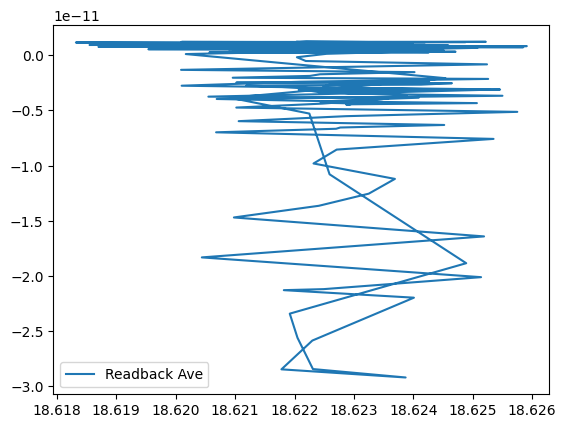

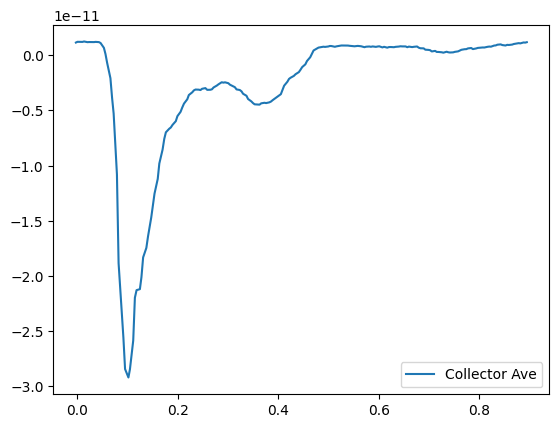

In [151]:
# Plots measured currents for collector
collector_average = []
driver_average = []
readback_average = []

for i in range(iterates):
   # plt.plot(aggregate_timestamps[i],aggregate_collector_measurements[i],label='Collector %s'%i)
    print('Collector average {iterate} is {value}'.format(iterate=i,value=np.average(aggregate_collector_measurements[i])))
    print('Driver average {iterate} is {value}'.format(iterate=i,value=np.average(aggregate_mass_driver_measurements[i])))
    print('Readback average {iterate} is {value}'.format(iterate=i,value=np.average(aggregate_readback_measurements[i])))
    collector_average.append(float(np.average(aggregate_collector_measurements[i])))
    driver_average.append(float(np.average(aggregate_mass_driver_measurements[i])))
    readback_average.append(float(np.average(aggregate_readback_measurements[i])))
    #plt.plot(float(driver_average[i]),float(collector_average[i]),label='Collector %s'%i)
    #print(driver_average[i])

plt.figure(0)
plt.plot(readback_average,collector_average,label='Readback Ave')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(driver_average,collector_average,label='Collector Ave')
plt.legend()
plt.show()

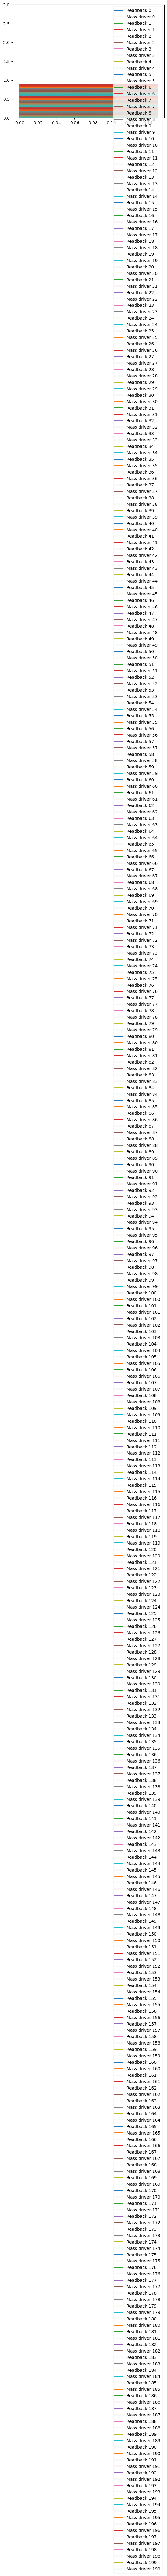

In [152]:
# Plots measured voltages for driver and readback
for i in range(iterates):
    plt.plot(aggregate_timestamps[i],aggregate_readback_measurements[i],label='Readback %s'%i)
    plt.plot(aggregate_timestamps[i],aggregate_mass_driver_measurements[i],label='Mass driver %s'%i)

plt.ylim(0,3)
plt.legend()
plt.show()

In [153]:
dts = []
for i in range(len(aggregate_timestamps[0]) - 1):
    dts.append(aggregate_timestamps[0][i + 1] - aggregate_timestamps[0][i])
print(np.average(dts))
print(1 / np.average(dts))

0.016698666666666667
59.88502076014053


In [154]:
aggregate_data = {'voltage':operating_voltage,'times':aggregate_timestamps,'measured_collector_currents':aggregate_collector_measurements,'measured_mass_driver_voltages':aggregate_mass_driver_measurements,'measured_readback_voltages':aggregate_readback_measurements,'mass_driver_average':driver_average,'readback_average':readback_average,'average_collector_currents':collector_average}

# filename = data_dir + experiment_name + '_ %s'%datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S') + '.json'
#
# with open(filename, 'w') as file:
#     json.dump(aggregate_data, file)
#
# print('saved to %s' %{filename})

In [155]:
import pandas as pd
from pathlib import Path
# import numpy as np
data = {'Voltages': driver_average,
        'Currents': collector_average
        }

# Convert the dictionary into DataFrame
df = pd.DataFrame(data)
df.to_csv(index=False)
filename = data_dir + experiment_name + '_ %s'%datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S') + '.csv'

filepath = Path(filename)
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)
print('saved to %s' %{filename})

saved to {'C://Users//addiaz15//Desktop//keithleydataDec19//ms sweep testing_ 2022_12_20-02_11_19.csv'}


In [156]:
#Turn off output and drain capacitors
print("Closing Keithley connection")
collector.close()
mass_driver.close()
readback.close()

Closing Keithley connection
